## Create Agents

In [20]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
# "당신은 다른 AI 어시스턴트들과 협력하는 유용한 AI 어시스턴트입니다."
# "질문에 답을 진행하기 위해 제공된 도구들을 사용하세요."
# "만약 질문에 완전히 답하지 못하더라도 괜찮습니다. 다른 도구를 가진 또 다른 어시스턴트가"
# "당신이 멈춘 부분을 도울 것입니다. 할 수 있는 만큼 실행하여 진전을 이루세요."
# "만약 당신이나 다른 어시스턴트가 최종 답변이나 결과물을 가지고 있다면,"
# "응답의 시작에 'FINAL ANSWER'라고 표기하여 팀이 멈추도록 하세요."
# "당신은 다음 도구들에 접근할 수 있습니다: {tool_names}.\n{system_message}"

## Define tools

In [21]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [22]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Define State

- 그래프의 상태 정의
- 단순히 메세지 목록과 가장 최근에 메세지를 보낸 발신저를 추적하는 키로 구성됨

In [23]:
import operator
from typing import Annotated, Sequence, TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Define Agent Nodes
- 에이전트를 위한 노드 정의

In [24]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4o")

## 검색을 이용하는 Research Agent 생성

In [25]:
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

## Python 코드 실행기를 사용하는 차트 에이전트 생성

In [26]:
# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

## Define Tool Node

In [27]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

## Define Edge Logic

In [28]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [29]:
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

# router라는 함수를 사용하여 에이전트의 상태에 따라 다음 노드를 결정
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

# 도구를 호출하는 노드("call_tool")에서 다시 원래 도구를 호출한 에이전트 노드로 돌아가는 경로를 설정
# 도구의 결과를 에이전트가 처리할 수 있도록 하기 위함
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

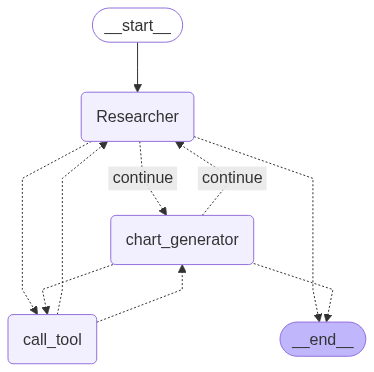

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


/var/folders/q5/zkf2r1390jl_wp2gxm05m0wc0000gn/T/ipykernel_29454/3458347367.py:10: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_U3RRnHlHd2yFY7KK6vSeVK9B', 'function': {'arguments': '{"query": "USA GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Vh7YgXtXu5NV8y8cfMVSHClM', 'function': {'arguments': '{"query": "USA GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_AQBRiESiDZqu0wTGrrLurMmQ', 'function': {'arguments': '{"query": "USA GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 223, 'total_tokens': 305, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bf6PDLoMMatGlz7VMNZQN2b3sMjxw', 

/var/folders/q5/zkf2r1390jl_wp2gxm05m0wc0000gn/T/ipykernel_29454/3458347367.py:10: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='Here are the GDP figures for the United States over the past three years:\n\n- **2020:** $21.323 trillion USD\n- **2021:** $23.594 trillion USD\n- **2022:** $25.744 trillion USD\n\nI will now write the code to draw a line graph for this data.\n```python\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [2020, 2021, 2022]\ngdp_values = [21.323, 23.594, 25.744]\n\n# Plotting the graph\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title("USA GDP Over The Past 3 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP in Trillions of USD")\nplt.xticks(years)\nplt.grid(True)\nplt.show()\n```\n\nThis code uses `matplotlib` to create a line graph displaying the GDP of the USA from 2020 to 2022. You can run this code in a Python environment with `matplotlib` installed to visualize the GDP trend over these years.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 235, 'prompt_tokens'

/var/folders/q5/zkf2r1390jl_wp2gxm05m0wc0000gn/T/ipykernel_29454/3458347367.py:10: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xAO0ck81YKH35gtglKQmjxnu', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data\\nyears = [2020, 2021, 2022]\\ngdp_values = [21.323, 23.594, 25.744]\\n\\n# Plotting the graph\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\\"USA GDP Over The Past 3 Years\\")\\nplt.xlabel(\\"Year\\")\\nplt.ylabel(\\"GDP in Trillions of USD\\")\\nplt.xticks(years)\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 5625, 'total_tokens': 5766, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8',

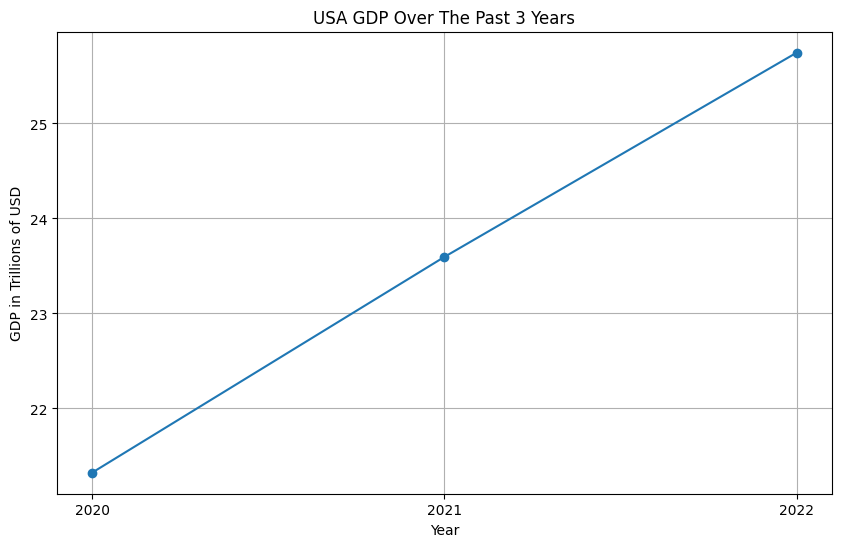

{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [2020, 2021, 2022]\ngdp_values = [21.323, 23.594, 25.744]\n\n# Plotting the graph\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title("USA GDP Over The Past 3 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP in Trillions of USD")\nplt.xticks(years)\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.', name='python_repl', tool_call_id='call_xAO0ck81YKH35gtglKQmjxnu')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER Here is the line graph showing the USA's GDP over the past 3 years:\n\n- **2020:** $21.323 trillion USD\n- **2021:** $23.594 trillion USD\n- **2022:** $25.744 trillion USD\n\nThe graph has been successfully generated, displaying the increasing trend in GDP from 2020 to 2022.", additional_kwargs={'refusal': None}, response_metadata={'token_

/var/folders/q5/zkf2r1390jl_wp2gxm05m0wc0000gn/T/ipykernel_29454/3458347367.py:10: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [34]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the USA's GDP over the past 3 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 20},
)
for s in events:
    print(s)
    print("----")